In [1]:
import pandas as pd
import numpy as np
import time
import datetime
from sklearn.metrics import f1_score
from sklearn.utils import class_weight
from xgboost import XGBClassifier
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from xgboost import plot_importance
from sklearn.ensemble import RandomForestClassifier

In [2]:
!pip install catboost
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.6 MB 62 kB/s 


##data analysis

In [3]:
!wget --header 'Host: datahack-prod.s3.amazonaws.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:100.0) Gecko/20100101 Firefox/100.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://datahack.analyticsvidhya.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-Fetch-Dest: document' --header 'Sec-Fetch-Mode: navigate' --header 'Sec-Fetch-Site: cross-site' --header 'Sec-Fetch-User: ?1' 'https://datahack-prod.s3.amazonaws.com/train_file/train_wn75k28.csv' --output-document 'train_wn75k28.csv'

--2022-06-05 16:43:07--  https://datahack-prod.s3.amazonaws.com/train_file/train_wn75k28.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.160.167
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.160.167|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2216460 (2.1M) [text/csv]
Saving to: ‘train_wn75k28.csv’

train_wn75k28.csv   100%[===================>]   2.11M  1.23MB/s    in 1.7s    

2022-06-05 16:43:10 (1.23 MB/s) - ‘train_wn75k28.csv’ saved [2216460/2216460]



In [4]:
df=pd.read_csv("train_wn75k28.csv")
df.head(2)

,id,created_at,campaign_var_1,campaign_var_2,products_purchased,signup_date,user_activity_var_1,user_activity_var_2,user_activity_var_3,user_activity_var_4,user_activity_var_5,user_activity_var_6,user_activity_var_7,user_activity_var_8,user_activity_var_9,user_activity_var_10,user_activity_var_11,user_activity_var_12,buy
0,1,2021-01-01,1,2,2.0,2020-09-24,0,0,0,0,0,0,1,1,0,0,0,0,0
1,2,2021-01-01,2,1,2.0,2020-09-19,1,0,1,0,0,0,1,0,0,0,0,0,0


In [5]:
def dates(string):
  try:
    return time.mktime(datetime.datetime.strptime(string,"%Y-%m-%d").timetuple())
  except:
    return np.nan
df.created_at=df.created_at.apply(dates)
df.signup_date=df.signup_date.apply(dates)

In [6]:
print('% of null signup dates',df.signup_date.isnull().sum()/df.shape[0])
print('% of null created at dates',df.created_at.isnull().sum()/df.shape[0])

% of null signup dates 0.38591966497280455
% of null created at dates 0.0


lets try to replace null signup dates with created at dates

In [7]:
k=df[df.signup_date.isnull()].index
for i in k:
  df.signup_date.iloc[i]=df.created_at.iloc[i]

df['diff']=df['signup_date']-df['created_at']

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [8]:
for i in df.columns:
  if df[i].isnull().sum()>0:
   print(df[i].isnull().sum(),i)

20911 products_purchased


## products purchase

In [9]:
data=df.dropna()
y=data.products_purchased
x=data.drop(['id','signup_date','buy','products_purchased'],axis=1)

In [10]:
class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y),
                                        y = y )
class_weights=dict(zip(np.unique(y), class_weights))
class_weights

{1.0: 1.2524018665934669,
 2.0: 0.5145483252509304,
 3.0: 0.908140923566879,
 4.0: 6.3722067039106145}

In [11]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(multi_class='multinomial',class_weight=class_weights)
lr.fit(x,y)

LogisticRegression(class_weight={1.0: 1.2524018665934669,
                                 2.0: 0.5145483252509304,
                                 3.0: 0.908140923566879,
                                 4.0: 6.3722067039106145},
                   multi_class='multinomial')

In [12]:
k=df[df.products_purchased.isnull()].index
data=df.drop(['id','signup_date','buy','products_purchased'],axis=1)
j=lr.predict(data)
for i in k:
  df['products_purchased'].iloc[i]=j[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


##rest

In [13]:
for i in df.columns:
  if len(df[i].unique())>2:
    print(i,len(df[i].unique()))

id 39161
created_at 365
campaign_var_1 16
campaign_var_2 15
products_purchased 4
signup_date 1800
user_activity_var_1 4
user_activity_var_5 3
user_activity_var_6 4
user_activity_var_7 3
user_activity_var_8 3
user_activity_var_11 5
diff 1940


In [14]:
def ohe(df):
  var1_dummy=pd.get_dummies(df['campaign_var_1'],prefix='campaign_var_1')
  var2_dummy=pd.get_dummies(df['campaign_var_2'],prefix='campaign_var_2')
  '''
  uv1_dummy=pd.get_dummies(df['user_activity_var_1'],prefix='user_activity_var_1')
  uv5_dummy=pd.get_dummies(df['user_activity_var_5'],prefix='user_activity_var_5')
  uv6_dummy=pd.get_dummies(df['user_activity_var_6'],prefix='user_activity_var_6')
  uv7_dummy=pd.get_dummies(df['user_activity_var_7'],prefix='user_activity_var_7')
  uv8_dummy=pd.get_dummies(df['user_activity_var_8'],prefix='user_activity_var_8')
  uv11_dummy=pd.get_dummies(df['user_activity_var_11'],prefix='user_activity_var_11')
  '''
  train=pd.concat([df,var1_dummy,var2_dummy],axis=1)#,uv1_dummy,uv5_dummy,uv6_dummy,uv7_dummy,uv8_dummy,uv11_dummy],axis=1)
  train.drop(['campaign_var_1','campaign_var_2'],axis=1,inplace=True)#,'user_activity_var_1','user_activity_var_5','user_activity_var_6','user_activity_var_7','user_activity_var_8','user_activity_var_11'],axis=1,inplace=True)
  return train

train=ohe(df)

In [15]:
y=train.buy
x=train.drop(['buy','id','signup_date'],axis=1)

data is highly imbalanced

In [16]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y,random_state=15)

In [17]:
def f1_eval(y_pred, dtrain):
    y_true = dtrain.get_label()
    err = 1-f1_score(y_true, np.round(y_pred))
    return 'f1_err', err

class_weights = class_weight.compute_class_weight(class_weight = "balanced",
                                        classes = np.unique(y),
                                        y = y )
class_weights=dict(zip(np.unique(y), class_weights))
class_weights

{0: 0.5268815757608374, 1: 9.80005005005005}

In [18]:
model = XGBClassifier(learning_rate=0.01,
                      max_depth = 8, 
                      n_estimators = 1800,scale_pos_weight=1.5)
eval_set = [(X_train, y_train), (X_test, y_test)]
model.fit(x,y,eval_metric=f1_eval, eval_set=eval_set, verbose=False)
confusion_matrix(y_test,model.predict(X_test)),f1_score(y_test,model.predict(X_test))

(array([[7425,    8],
        [ 132,  268]]), 0.7928994082840237)

In [19]:
lgbm=LGBMClassifier(max_depth=8, learning_rate=0.01, n_estimators=1850,scale_pos_weight=1.5)
lgbm.fit(x,y)
confusion_matrix(y_test,lgbm.predict(X_test)),f1_score(y_test,lgbm.predict(X_test))

(array([[7424,    9],
        [ 133,  267]]), 0.7899408284023668)

In [20]:
cb = CatBoostClassifier(iterations=1890,learning_rate=0.01,depth=8,scale_pos_weight=1.5)
cb.fit(x,y, verbose=False)
confusion_matrix(y_test,cb.predict(X_test)),f1_score(y_test,cb.predict(X_test))

(array([[7425,    8],
        [ 134,  266]]), 0.7893175074183976)

.7275 800

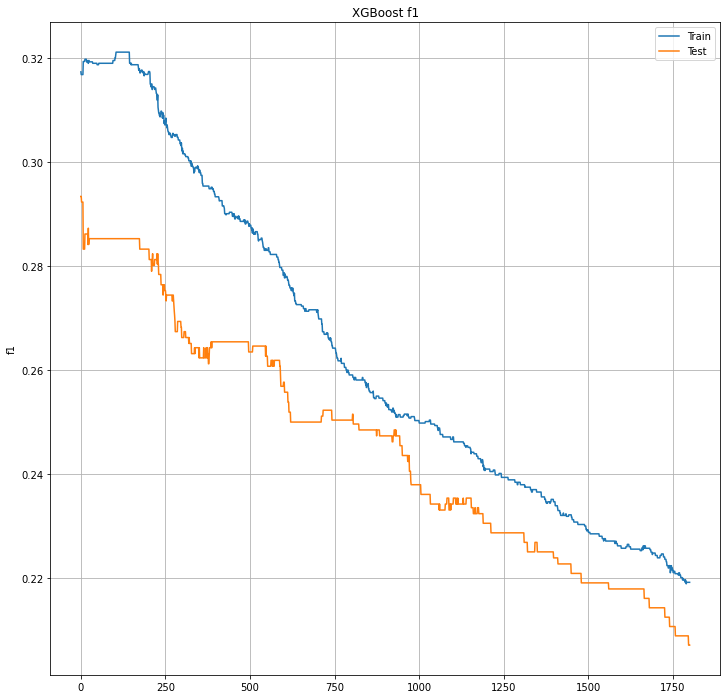

In [21]:
results = model.evals_result()
epochs = len(results['validation_0']['f1_err'])
x_axis = range(0, epochs)
fig, ax = plt.subplots(figsize=(12,12))
ax.plot(x_axis, results['validation_0']['f1_err'], label='Train')
ax.plot(x_axis, results['validation_1']['f1_err'], label='Test')
ax.legend()
plt.ylabel('f1')
plt.title('XGBoost f1')
plt.grid()
plt.show()

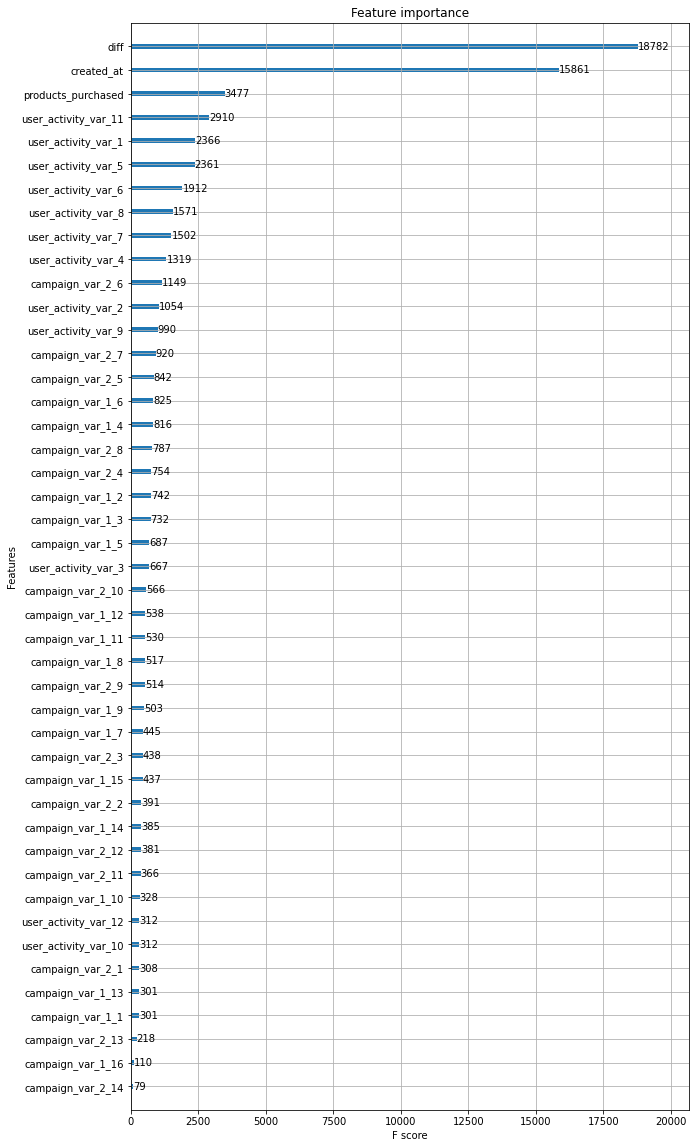

In [22]:
fig, ax = plt.subplots(figsize=(10, 20))
plot_importance(model,ax=ax)
plt.show()

In [23]:
pred=pd.DataFrame()
pred['xgb']=model.predict(x)
pred['cb']=cb.predict(x)
pred['lgbm']=lgbm.predict(x)
X=pd.concat([x.reset_index(drop=True),pred.reset_index(drop=True)],axis=1)

In [39]:
cb2 = CatBoostClassifier(iterations=1820,learning_rate=0.01,depth=8,scale_pos_weight=1.5)
cb2.fit(X,y, verbose=False)

XGBClassifier(learning_rate=0.01, max_depth=8, n_estimators=1800,
              scale_pos_weight=1.5)

## test

In [25]:
!wget --header 'Host: datahack-prod.s3.amazonaws.com' --user-agent 'Mozilla/5.0 (X11; Ubuntu; Linux x86_64; rv:100.0) Gecko/20100101 Firefox/100.0' --header 'Accept: text/html,application/xhtml+xml,application/xml;q=0.9,image/avif,image/webp,*/*;q=0.8' --header 'Accept-Language: en-US,en;q=0.5' --referer 'https://datahack.analyticsvidhya.com/' --header 'DNT: 1' --header 'Upgrade-Insecure-Requests: 1' --header 'Sec-Fetch-Dest: document' --header 'Sec-Fetch-Mode: navigate' --header 'Sec-Fetch-Site: cross-site' --header 'Sec-Fetch-User: ?1' 'https://datahack-prod.s3.amazonaws.com/test_file/test_Wf7sxXF.csv' --output-document 'test_Wf7sxXF.csv'

--2022-06-05 16:49:31--  https://datahack-prod.s3.amazonaws.com/test_file/test_Wf7sxXF.csv
Resolving datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)... 52.219.62.16
Connecting to datahack-prod.s3.amazonaws.com (datahack-prod.s3.amazonaws.com)|52.219.62.16|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 708421 (692K) [text/csv]
Saving to: ‘test_Wf7sxXF.csv’

test_Wf7sxXF.csv    100%[===================>] 691.82K   571KB/s    in 1.2s    

2022-06-05 16:49:33 (571 KB/s) - ‘test_Wf7sxXF.csv’ saved [708421/708421]



In [26]:
test=pd.read_csv("/content/test_Wf7sxXF.csv")

In [27]:
test.created_at=test.created_at.apply(dates)
test.signup_date=test.signup_date.apply(dates)

In [28]:
k=test[test.signup_date.isnull()].index
for i in k:
  test.signup_date.iloc[i]=test.created_at.iloc[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [29]:
test['diff']=test['signup_date']-test['created_at']

In [30]:
k=test[test.products_purchased.isnull()].index
data=test.drop(['id','signup_date','products_purchased'],axis=1)
j=lr.predict(data)
for i in k:
  test['products_purchased'].iloc[i]=j[i]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [31]:
for i in test.columns:
  print(test[i].isnull().sum(),i)

0 id
0 created_at
0 campaign_var_1
0 campaign_var_2
0 products_purchased
0 signup_date
0 user_activity_var_1
0 user_activity_var_2
0 user_activity_var_3
0 user_activity_var_4
0 user_activity_var_5
0 user_activity_var_6
0 user_activity_var_7
0 user_activity_var_8
0 user_activity_var_9
0 user_activity_var_10
0 user_activity_var_11
0 user_activity_var_12
0 diff


In [32]:
#test['user_activity_var_11_4']=0

In [33]:
x_test=test.drop(['id','signup_date'],axis=1)

In [34]:
x_test=ohe(x_test)
test['buy']=model.predict(x_test)
submission=test[['id','buy']]
submission.to_csv("submission_xgb.csv",index=False)

In [35]:
test['buy']=lgbm.predict(x_test)
submission=test[['id','buy']]
submission.to_csv("submission_lgbm.csv",index=False)

In [36]:
test['buy']=cb.predict(x_test)
submission=test[['id','buy']]
submission.to_csv("submission_cb.csv",index=False)

In [37]:
pred=pd.DataFrame()
pred['xgb']=model.predict(x_test)
pred['cb']=cb.predict(x_test)
pred['lgbm']=lgbm.predict(x_test)
xtest=pd.concat([x_test.reset_index(drop=True),pred.reset_index(drop=True)],axis=1)

In [40]:
test['buy']=cb2.predict(xtest)
submission=test[['id','buy']]
submission.to_csv("submission_ensemble.csv",index=False)